# Parallelizing raster computations using Dask

Objectives:
- Profile the timing and memory footprint of your raster calculations. 
- Open raster data as a "chunked" array.
- Recognize good practices in selecting proper chunk sizes.
- Setup raster calculations that take advantage of parallelization.

In [1]:
# TODO: add packages to environment
# !pip install stackstac memory_profiler

In [2]:
%load_ext memory_profiler

## Profile your raster calculation in Jupyter

In [3]:
import pystac

# open search outcome of previous episode on data access
items = pystac.ItemCollection.from_file("mysearch.json")

In [4]:
# get assets of last scene
assets = items[-1].assets

In [5]:
# Get Sentinel-2 scene classification layer, info at: 
# https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
scl_url = assets["SCL"].href

In [6]:
import rioxarray 

scl = rioxarray.open_rasterio(scl_url, cache=False)

In [7]:
def extract_water_bodies(scl):
    s = scl.squeeze()  # remove band dimension
    mask = s == 6  # select only pixels labeled as water bodies
    return s.where(mask)

In [8]:
%%time
%%memit
# profile timing and memory usage (ideally, independendently)
water = extract_water_bodies(scl)

peak memory: 695.72 MiB, increment: 525.09 MiB
CPU times: user 298 ms, sys: 212 ms, total: 511 ms
Wall time: 3.86 s


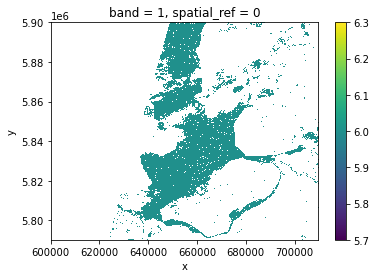

In [9]:
water.plot.imshow()

## Dask-powered `DataArray`'s

### Chunked rasters

In [10]:
# get link to blue-band asset
assets = items[-1].assets
blue_band_href = assets["B02"].href

In [11]:
# use Dask Arrays as underlying data structure by setting the "chunks" argument. Fully parallel read with lock=False.
blue_band = rioxarray.open_rasterio(blue_band_href, lock=False, chunks=(1, 4000, 4000))
blue_band

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-1fc2bc30c3f3a40deb14678b16a72c21<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 4000, 4000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

### Exercise: Chunk size matters
Cloud optimized GeoTIFFs (COGs) are GeoTIFF files with a special internal structure. One feature of COGs is that data is organized in "blocks" that can be accessed via independent HTTP requests, enabling partial file readings (and, thus, efficient parallel access!). You can check the blocksize employed in a COG file with the following code snippet:
```python
import rasterio
with rasterio.open(cog_uri) as r:
    if r.is_tiled:
        print(f"Chunk size: {r.block_shapes}")
    else:
        print("File is not tiled!")
```
In order to optimally access COGs it is best to align the blocksize of the file with the chunks employed for the file read. Open the blue-band asset (`B02`) of a Sentinel-2 scene as a chunked `DataArray` object using suitable chunksize values. Which elements do you think should be considered when choosing these values? 

#### Solution

In [12]:
band_url = assets["B02"].href

In [13]:
import rasterio
with rasterio.open(band_url) as r:
    if r.is_tiled:
        print(f"Chunk size: {r.block_shapes}")
    else:
        print("File is not tiled!")

Chunk size: [(1024, 1024)]


In [14]:
# Use multiple of 1024, but try to avoid too small chunks
band = rioxarray.open_rasterio(band_url, lock=False, chunks=(1, 6144, 6144))
band

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-dbc16986a53291040795564a01365171<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 6144, 6144), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [15]:
# rioxarray can also try to guess best values
band = rioxarray.open_rasterio(band_url, lock=False, chunks="auto")
band

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-e8d77d7b3d373b8236b23f13b5cf233d<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

### Lazy computations

In [16]:
scl = rioxarray.open_rasterio(scl_url, lock=False, chunks=(1, 2048, 2048))
scl

<xarray.DataArray (band: 1, y: 5490, x: 5490)>
dask.array<open_rasterio-37e1c32f709c03b98b5a5fb23cb1d553<this-array>, shape=(1, 5490, 5490), dtype=uint8, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [18]:
# immediately returns: calculation did not happen yet!
water = extract_water_bodies(scl)
water

<xarray.DataArray (y: 5490, x: 5490)>
dask.array<where, shape=(5490, 5490), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

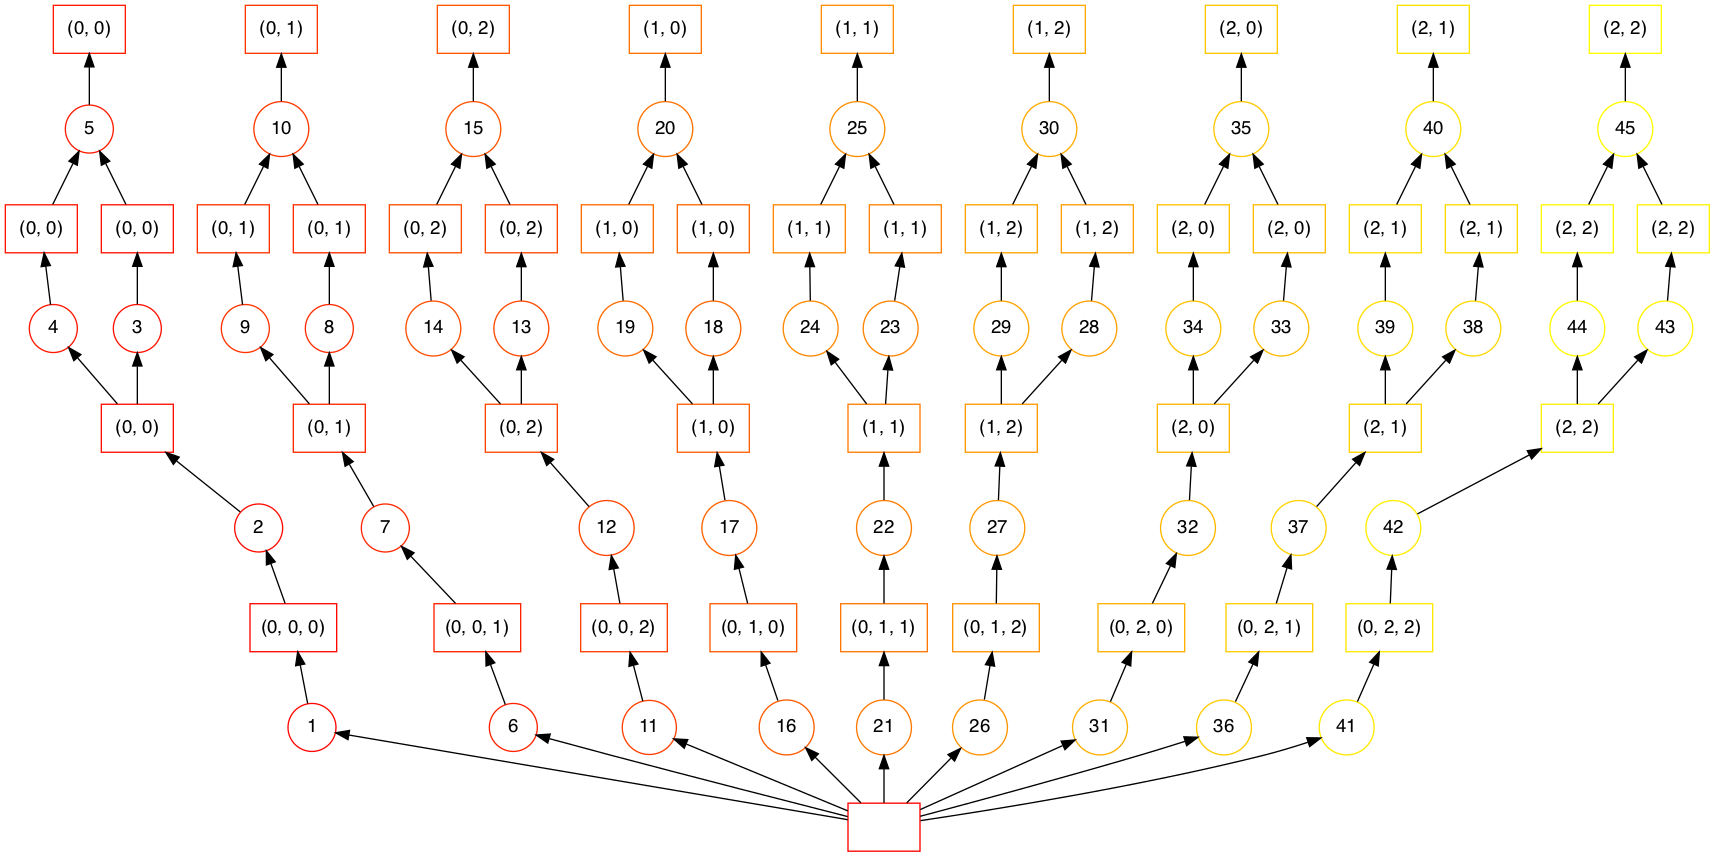

In [19]:
import dask
# coloring order in order of execution: almost "embarassingly" parallel workflow
dask.visualize(water, color="order", cmap="autumn")

In [20]:
%%time
%%memit
out = water.compute(scheduler="threads", num_workers=4)

peak memory: 1015.82 MiB, increment: 531.14 MiB
CPU times: user 670 ms, sys: 397 ms, total: 1.07 s
Wall time: 5.34 s


In [21]:
from dask.diagnostics import Profiler

# full profiling: are workers busy? do they spend most of the time communicating? 
with Profiler() as prof:
    out = water.compute(scheduler="threads", num_workers=4)

In [22]:
prof.visualize()

Figure(id='1002', ...)

In [23]:
# NOTE:  mention `rioxarray` limitations with Dask?
# https://github.com/corteva/rioxarray/issues/119

## From collection to mosaics using `stackstac`

In [24]:
import stackstac

In [25]:
# NOTE: mention CRS differences between stackstac and rioxarray
# https://github.com/gjoseph92/stackstac/issues/50

In [26]:
stackstac.stack(items)

/opt/miniconda3/envs/geospatial/lib/python3.10/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/opt/miniconda3/envs/geospatial/lib/python3.10/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))


,Array,Chunk
Bytes,1.20 TiB,8.00 MiB
Shape,"(42, 17, 20982, 10980)","(1, 1, 1024, 1024)"
Count,166593 Tasks,164934 Chunks
Type,float64,numpy.ndarray
